# Global Tweet Sentiment Analysis - Mood of the World { Free API Version }

# Install Required Packages

In [68]:
!pip install tweepy textblob plotly pandas numpy wordcloud matplotlib seaborn python-dotenv scikit-learn --quiet
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


# Import Libraries

In [69]:
import tweepy
import pandas as pd
import numpy as np
from textblob import TextBlob
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
from datetime import datetime, timedelta
import re
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pyo.init_notebook_mode(connected=True)

# Twitter API Configuration
## Note : get API from https://developer.twitter.com/


In [70]:
class TwitterConfig:
    def __init__(self):
        # Replace with your actual API credentials
        self.API_KEY = "YOUR_API_KEY"
        self.API_SECRET = "YOUR_API_SECRET"
        self.ACCESS_TOKEN = "YOUR_ACCESS_TOKEN"
        self.ACCESS_TOKEN_SECRET = "YOUR_ACCESS_TOKEN_SECRET"
        self.BEARER_TOKEN = "YOUR_BEARER_TOKEN"

        # Rate limit settings
        self.FREE_TIER_MONTHLY_LIMIT = 100
        self.DAILY_BUDGET = 10
        self.BATCH_SIZE = 25
        self.REQUEST_DELAY = 1.5

    def get_api_v1(self):
        """Get Twitter API v1.1 client"""
        auth = tweepy.OAuthHandler(self.API_KEY, self.API_SECRET)
        auth.set_access_token(self.ACCESS_TOKEN, self.ACCESS_TOKEN_SECRET)
        return tweepy.API(auth, wait_on_rate_limit=True)

    def get_api_v2(self):
        """Get Twitter API v2 client"""
        return tweepy.Client(
            bearer_token=self.BEARER_TOKEN,
            consumer_key=self.API_KEY,
            consumer_secret=self.API_SECRET,
            access_token=self.ACCESS_TOKEN,
            access_token_secret=self.ACCESS_TOKEN_SECRET,
            wait_on_rate_limit=True
        )
config = TwitterConfig()

# Data Collection Via API or Sample Data for Demonstration

In [71]:
class GlobalTweetCollector:
    def __init__(self, api_v1=None, api_v2=None):
        self.api_v1 = api_v1
        self.api_v2 = api_v2
        self.tweets_data = []

    def clean_tweet(self, text):
        """tweet cleaning"""
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+|#\w+', '', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[^\w\s\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]', '', text)
        return text.strip()

    def get_enhanced_sentiment(self, text):
        """sentiment analysis with confidence scores"""
        try:
            blob = TextBlob(text)
            polarity = blob.sentiment.polarity
            subjectivity = blob.sentiment.subjectivity
            if polarity > 0.2:
                sentiment = 'Positive'
                confidence = abs(polarity)
            elif polarity < -0.2:
                sentiment = 'Negative'
                confidence = abs(polarity)
            else:
                sentiment = 'Neutral'
                confidence = 1 - abs(polarity)
            emotion = self.detect_emotion(text.lower())

            return {
                'sentiment': sentiment,
                'polarity': polarity,
                'subjectivity': subjectivity,
                'confidence': confidence,
                'emotion': emotion,
                'word_count': len(text.split())
            }
        except Exception as e:
            return {
                'sentiment': 'Neutral',
                'polarity': 0.0,
                'subjectivity': 0.0,
                'confidence': 0.0,
                'emotion': 'neutral',
                'word_count': 0
            }

    def detect_emotion(self, text):
        """Detect basic emotions from text"""
        emotion_keywords = {
            'joy': ['happy', 'excited', 'great', 'wonderful', 'amazing', 'love', 'perfect'],
            'sadness': ['sad', 'depressed', 'down', 'upset', 'disappointed', 'lonely'],
            'anger': ['angry', 'mad', 'furious', 'annoyed', 'frustrated', 'hate'],
            'fear': ['scared', 'afraid', 'worried', 'anxious', 'nervous', 'panic'],
            'surprise': ['surprised', 'shocked', 'unexpected', 'wow', 'omg'],
            'gratitude': ['grateful', 'thankful', 'blessed', 'appreciate', 'lucky']
        }

        emotion_scores = {}
        for emotion, keywords in emotion_keywords.items():
            score = sum(1 for keyword in keywords if keyword in text)
            if score > 0:
                emotion_scores[emotion] = score

        if emotion_scores:
            return max(emotion_scores, key=emotion_scores.get)
        return 'neutral'

    def collect_tweets_with_api(self, keywords=None, count=50):
        """Collect tweets using Twitter API"""
        if not self.api_v2:
            print("Twitter API not configured")
            return pd.DataFrame()

        if keywords is None:
            keywords = ["feeling good", "having a great day", "feeling down", "stressed out", "grateful today"]

        print(f"Collecting tweets using Twitter API...")
        print(f"Target: {count} tweets across {len(keywords)} keywords")

        tweets_per_keyword = max(1, count // len(keywords))

        for i, keyword in enumerate(keywords):
            if len(self.tweets_data) >= count:
                break

            try:
                print(f"Searching: '{keyword}' ({i+1}/{len(keywords)})")

                tweets = self.api_v2.search_recent_tweets(
                    query=f'"{keyword}" -is:retweet lang:en',
                    tweet_fields=['created_at', 'author_id', 'public_metrics', 'context_annotations'],
                    max_results=min(tweets_per_keyword, 100)
                )

                if tweets.data:
                    for tweet in tweets.data:
                        if len(self.tweets_data) >= count:
                            break

                        cleaned_text = self.clean_tweet(tweet.text)
                        if len(cleaned_text) > 15:
                            sentiment_data = self.get_enhanced_sentiment(cleaned_text)

                            tweet_data = {
                                'id': tweet.id,
                                'text': cleaned_text,
                                'original_text': tweet.text,
                                'created_at': tweet.created_at,
                                'author_id': tweet.author_id,
                                'keyword': keyword,
                                'source': 'twitter_api',
                                **sentiment_data,
                                'retweet_count': tweet.public_metrics.get('retweet_count', 0) if tweet.public_metrics else 0,
                                'like_count': tweet.public_metrics.get('like_count', 0) if tweet.public_metrics else 0,
                            }

                            self.tweets_data.append(tweet_data)

                import time
                time.sleep(config.REQUEST_DELAY)

            except Exception as e:
                print(f"Error with '{keyword}': {str(e)}")
                if "rate limit" in str(e).lower():
                    print("Rate limit reached - switching to sample data")
                    break

        print(f"Collected {len(self.tweets_data)} real tweets")
        return pd.DataFrame(self.tweets_data)

    def generate_realistic_sample_data(self, size=1000):
        """Generate realistic sample data with patterns"""
        print(f" Generating {size} realistic sample tweets...")

        tweet_templates = {
            'positive': [
                "Just had the most amazing coffee this morning! ☀️",
                "Feeling incredibly grateful for my family today 💕",
                "Beautiful sunset tonight, life is good! 🌅",
                "Finally finished that project I've been working on! 🎉",
                "Met up with old friends today, such a perfect day! 😊",
                "Got some great news today, feeling so blessed! ✨",
                "Nothing beats a good workout to start the day! 💪",
                "Weekend vibes are hitting different today! 🌟",
                "Sometimes the little things make me the happiest 💝",
                "Accomplished so much today, feeling proud! 🏆"
            ],
            'negative': [
                "Having one of those days where nothing goes right 😔",
                "Really struggling to find motivation lately",
                "Work has been incredibly stressful this week",
                "Feeling overwhelmed with everything going on",
                "Just need a break from all this chaos",
                "When will things start looking up? 😞",
                "Another sleepless night ahead of me",
                "Can't seem to catch a break these days",
                "Feeling disconnected from everyone lately",
                "This weather is really getting me down"
            ],
            'neutral': [
                "Just another typical Monday morning",
                "Regular day at the office, nothing special",
                "Weather looks okay for the weekend",
                "Going through my usual routine today",
                "Standard Tuesday, same as always",
                "Just checking in, hope everyone's well",
                "Another day, another dollar as they say",
                "Normal evening at home tonight",
                "Regular coffee meeting this afternoon",
                "Just going with the flow today"
            ]
        }

        emotions_dist = {'positive': 0.45, 'negative': 0.25, 'neutral': 0.30}
        sample_data = []
        end_date = datetime.now()
        start_date = end_date - timedelta(days=7)
        timestamps = pd.date_range(start=start_date, end=end_date, periods=size)

        for i, timestamp in enumerate(timestamps):
            hour = timestamp.hour
            day_of_week = timestamp.weekday()

            if 7 <= hour <= 10:
                pos_boost = 0.15
            elif 18 <= hour <= 21:
                pos_boost = 0.10
            elif 23 <= hour <= 2:
                pos_boost = -0.20
            elif day_of_week >= 5:
                pos_boost = 0.12
            else:
                pos_boost = 0

            adjusted_pos = min(0.7, emotions_dist['positive'] + pos_boost)
            adjusted_neg = max(0.1, emotions_dist['negative'] - pos_boost/2)
            adjusted_neu = 1 - adjusted_pos - adjusted_neg

            sentiment_choice = np.random.choice(
                ['positive', 'negative', 'neutral'],
                p=[adjusted_pos, adjusted_neg, adjusted_neu]
            )

            template = np.random.choice(tweet_templates[sentiment_choice])

            variations = {
                'positive': ['!', ' 🙂', ' Today was good.', ' Feeling blessed.'],
                'negative': ['...', ' 😕', ' Not my best day.', ' Hope tomorrow is better.'],
                'neutral': ['.', ' Just saying.', ' That\'s life.', ' Moving on.']
            }

            text = template + np.random.choice(variations[sentiment_choice])

            sentiment_data = self.get_enhanced_sentiment(text)

            if sentiment_choice == 'positive':
                likes = np.random.poisson(8)
                retweets = np.random.poisson(2)
            elif sentiment_choice == 'negative':
                likes = np.random.poisson(3)
                retweets = np.random.poisson(1)
            else:
                likes = np.random.poisson(4)
                retweets = np.random.poisson(1)

            sample_data.append({
                'id': f'sample_{i}',
                'text': text,
                'original_text': text,
                'created_at': timestamp,
                'author_id': f'user_{i % 100}',
                'keyword': np.random.choice(['mood', 'feeling', 'day', 'life', 'today']),
                'source': 'sample_data',
                **sentiment_data,
                'like_count': likes,
                'retweet_count': retweets,
            })

        print(f"Generated {len(sample_data)} realistic sample tweets")
        return pd.DataFrame(sample_data)

# Initialize APIs and Collect Data

In [72]:
def initialize_data_collection():
    """Initialize data collection with fallback options"""
    collector = GlobalTweetCollector()
    df_final = pd.DataFrame()

    try:
        print("Attempting Twitter API connection...")
        api_v1 = config.get_api_v1()
        api_v2 = config.get_api_v2()

        me = api_v1.verify_credentials()
        if me:
            print(f"Connected as: @{me.screen_name}")
            collector.api_v1 = api_v1
            collector.api_v2 = api_v2

            df_real = collector.collect_tweets_with_api(count=config.DAILY_BUDGET)
            if len(df_real) > 0:
                df_final = pd.concat([df_final, df_real], ignore_index=True)
                print(f"Added {len(df_real)} real tweets")

    except Exception as e:
        print(f"Twitter API issue: {str(e)[:100]}...")
        print("Continuing with sample data only")

    print("\nGenerating comprehensive sample dataset...")
    df_sample = collector.generate_realistic_sample_data(1200)
    df_final = pd.concat([df_final, df_sample], ignore_index=True)

    df_final['created_at'] = pd.to_datetime(df_final['created_at'])
    df_final['hour'] = df_final['created_at'].dt.hour
    df_final['day_of_week'] = df_final['created_at'].dt.day_name()
    df_final['date'] = df_final['created_at'].dt.date
    df_final['is_weekend'] = df_final['created_at'].dt.weekday >= 5

    print(f"\n Final dataset ready!")
    print(f"Total tweets: {len(df_final):,}")
    print(f"Real tweets: {len(df_final[df_final['source'] == 'twitter_api']):,}")
    print(f"Sample tweets: {len(df_final[df_final['source'] == 'sample_data']):,}")
    print(f"Date range: {df_final['created_at'].min().date()} to {df_final['created_at'].max().date()}")

    return df_final, collector

df_tweets, collector = initialize_data_collection()

Attempting Twitter API connection...
Twitter API issue: 401 Unauthorized
89 - Invalid or expired token....
Continuing with sample data only

Generating comprehensive sample dataset...
 Generating 1200 realistic sample tweets...
Generated 1200 realistic sample tweets

 Final dataset ready!
Total tweets: 1,200
Real tweets: 0
Sample tweets: 1,200
Date range: 2025-06-22 to 2025-06-29


# Data Analysis

In [73]:
class EnhancedSentimentAnalyzer:
    def __init__(self, df):
        self.df = df.copy()
        self.summary_stats = self.calculate_summary_stats()

    def calculate_summary_stats(self):
        """Calculate comprehensive summary statistics"""
        total_tweets = len(self.df)
        sentiment_counts = self.df['sentiment'].value_counts()

        return {
            'total_tweets': total_tweets,
            'unique_users': self.df['author_id'].nunique(),
            'date_range': (self.df['created_at'].min(), self.df['created_at'].max()),
            'positive_pct': (sentiment_counts.get('Positive', 0) / total_tweets) * 100,
            'negative_pct': (sentiment_counts.get('Negative', 0) / total_tweets) * 100,
            'neutral_pct': (sentiment_counts.get('Neutral', 0) / total_tweets) * 100,
            'avg_polarity': self.df['polarity'].mean(),
            'avg_subjectivity': self.df['subjectivity'].mean(),
            'avg_confidence': self.df['confidence'].mean(),
            'avg_word_count': self.df['word_count'].mean(),
            'total_engagement': self.df['like_count'].sum() + self.df['retweet_count'].sum(),
            'top_emotions': self.df['emotion'].value_counts().head().to_dict()
        }

    def get_time_analysis(self):
        """Comprehensive time-based analysis"""
        hourly = self.df.groupby('hour').agg({
            'polarity': ['mean', 'std', 'count'],
            'subjectivity': 'mean',
            'confidence': 'mean',
            'like_count': 'sum'
        }).round(3)

        daily = self.df.groupby('day_of_week').agg({
            'polarity': ['mean', 'std', 'count'],
            'subjectivity': 'mean',
            'confidence': 'mean'
        }).round(3)

        return hourly, daily

    def get_emotion_analysis(self):
        """Analyze emotional patterns"""
        emotion_sentiment = pd.crosstab(self.df['emotion'], self.df['sentiment'], normalize='index') * 100
        emotion_by_hour = self.df.groupby(['hour', 'emotion']).size().unstack(fill_value=0)

        return emotion_sentiment, emotion_by_hour

    def get_engagement_analysis(self):
        """Analyze engagement patterns"""
        engagement_by_sentiment = self.df.groupby('sentiment').agg({
            'like_count': ['mean', 'sum'],
            'retweet_count': ['mean', 'sum'],
            'confidence': 'mean'
        }).round(2)

        return engagement_by_sentiment

analyzer = EnhancedSentimentAnalyzer(df_tweets)
summary = analyzer.summary_stats

print("\n MOOD of the World Analysis")
print("=" * 50)
print(f"Dataset Overview:")
print(f"   • Total Tweets: {summary['total_tweets']:,}")
print(f"   • Unique Users: {summary['unique_users']:,}")
print(f"   • Date Range: {summary['date_range'][0].date()} to {summary['date_range'][1].date()}")
print(f"\n Sentiment Distribution:")
print(f"   • Positive: {summary['positive_pct']:.1f}%")
print(f"   • Negative: {summary['negative_pct']:.1f}%")
print(f"   • Neutral: {summary['neutral_pct']:.1f}%")
print(f"\n Quality Metrics:")
print(f"   • Average Polarity: {summary['avg_polarity']:.3f}")
print(f"   • Average Confidence: {summary['avg_confidence']:.3f}")
print(f"   • Average Word Count: {summary['avg_word_count']:.1f}")
print(f"\n Engagement:")
print(f"   • Total Likes + Retweets: {summary['total_engagement']:,}")
print(f"\n Top Emotions:")
for emotion, count in summary['top_emotions'].items():
    print(f"   • {emotion.title()}: {count:,}")


 MOOD of the World Analysis
Dataset Overview:
   • Total Tweets: 1,200
   • Unique Users: 100
   • Date Range: 2025-06-22 to 2025-06-29

 Sentiment Distribution:
   • Positive: 52.8%
   • Negative: 5.7%
   • Neutral: 41.5%

 Quality Metrics:
   • Average Polarity: 0.342
   • Average Confidence: 0.764
   • Average Word Count: 9.2

 Engagement:
   • Total Likes + Retweets: 8,769

 Top Emotions:
   • Neutral: 825
   • Joy: 177
   • Gratitude: 166
   • Sadness: 32


# Standard Plotting Functions and Time Series

Standard Visualizations...

 Sentiment Overview... 



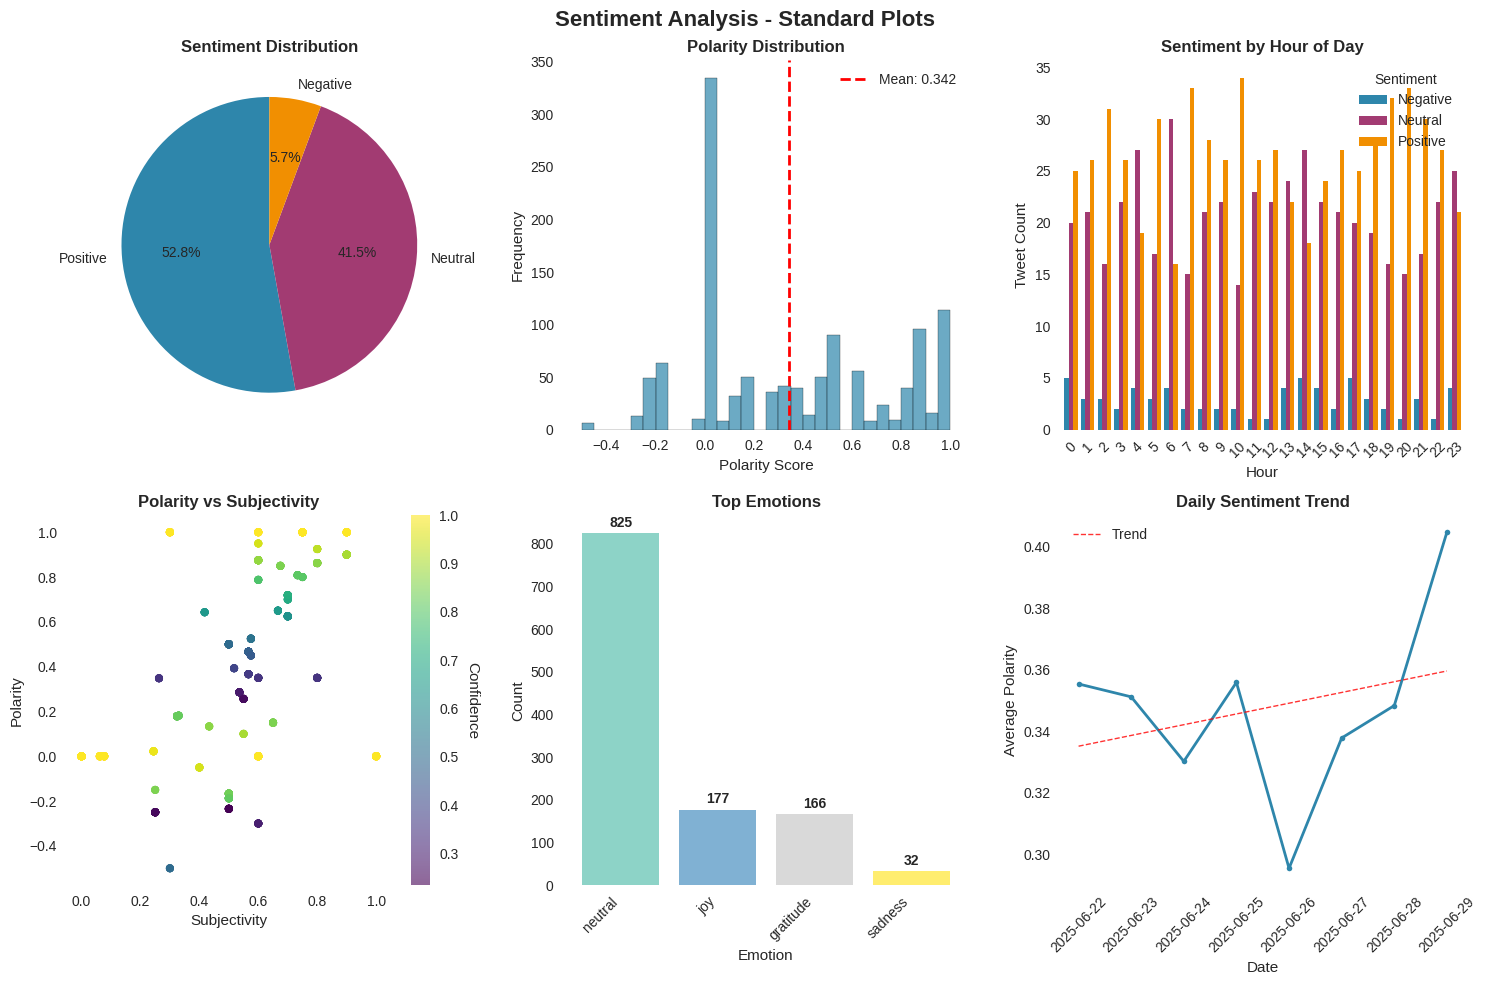


 Time Analysis...



<Figure size 800x550 with 0 Axes>

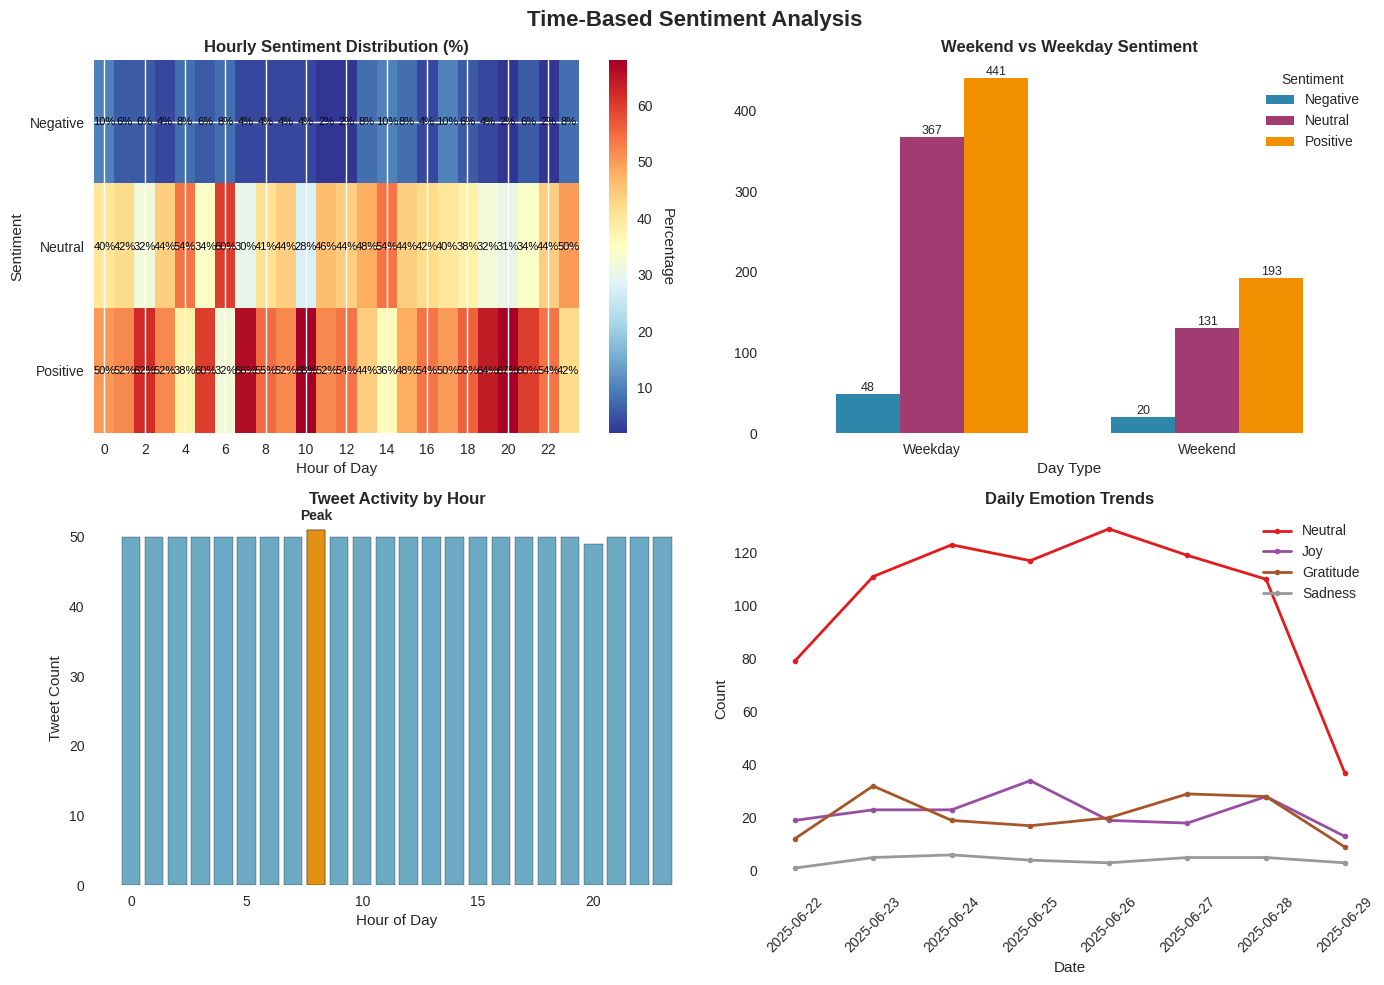


 Quick Stats:

   • Most active hour: 8:00
   • Most positive hour: 20:00
   • Weekend mood: 0.361
   • Weekday mood: 0.334
   • Top emotion: Neutral


<Figure size 800x550 with 0 Axes>

In [74]:
class StandardPlotter:
    def __init__(self, df, analyzer):
        self.df = df
        self.analyzer = analyzer
        # plt.style.use('default')  # Changed from 'seaborn-v0_8' which might not be available
        plt.rcParams['figure.facecolor'] = 'white'
        plt.rcParams['axes.facecolor'] = 'white'

    def plot_sentiment_overview(self, figsize=(15, 10)):
        """Create comprehensive standard plots overview"""
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle('Sentiment Analysis - Standard Plots', fontsize=16, fontweight='bold')

        sentiment_counts = self.df['sentiment'].value_counts()
        colors = ['#2E86AB', '#A23B72', '#F18F01']
        wedges, texts, autotexts = axes[0, 0].pie(
            sentiment_counts.values,
            labels=sentiment_counts.index,
            autopct='%1.1f%%',
            colors=colors,
            startangle=90,
            textprops={'fontsize': 10}
        )
        axes[0, 0].set_title('Sentiment Distribution', fontweight='bold')

        axes[0, 1].hist(self.df['polarity'], bins=30, color='#2E86AB', alpha=0.7, edgecolor='black')
        mean_polarity = self.df['polarity'].mean()
        axes[0, 1].axvline(mean_polarity, color='red', linestyle='--', linewidth=2,
                          label=f'Mean: {mean_polarity:.3f}')
        axes[0, 1].set_title('Polarity Distribution', fontweight='bold')
        axes[0, 1].set_xlabel('Polarity Score')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        hourly_sentiment = self.df.groupby(['hour', 'sentiment']).size().unstack(fill_value=0)
        hourly_sentiment.plot(kind='bar', ax=axes[0, 2], color=colors, width=0.8)
        axes[0, 2].set_title('Sentiment by Hour of Day', fontweight='bold')
        axes[0, 2].set_xlabel('Hour')
        axes[0, 2].set_ylabel('Tweet Count')
        axes[0, 2].legend(title='Sentiment', loc='upper right')
        axes[0, 2].tick_params(axis='x', rotation=45)
        axes[0, 2].grid(True, alpha=0.3)

        scatter = axes[1, 0].scatter(
            self.df['subjectivity'],
            self.df['polarity'],
            c=self.df['confidence'],
            cmap='viridis',
            alpha=0.6,
            s=30
        )
        axes[1, 0].set_title('Polarity vs Subjectivity', fontweight='bold')
        axes[1, 0].set_xlabel('Subjectivity')
        axes[1, 0].set_ylabel('Polarity')
        axes[1, 0].grid(True, alpha=0.3)
        cbar = plt.colorbar(scatter, ax=axes[1, 0])
        cbar.set_label('Confidence', rotation=270, labelpad=15)

        emotion_counts = self.df['emotion'].value_counts().head(8)
        bars = axes[1, 1].bar(
            range(len(emotion_counts)),
            emotion_counts.values,
            color=plt.cm.Set3(np.linspace(0, 1, len(emotion_counts)))
        )
        axes[1, 1].set_title('Top Emotions', fontweight='bold')
        axes[1, 1].set_xlabel('Emotion')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].set_xticks(range(len(emotion_counts)))
        axes[1, 1].set_xticklabels(emotion_counts.index, rotation=45, ha='right')
        axes[1, 1].grid(True, alpha=0.3)

        for bar, value in zip(bars, emotion_counts.values):
            axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(emotion_counts.values)*0.01,
                           str(value), ha='center', va='bottom', fontweight='bold')

        daily_polarity = self.df.groupby(self.df['created_at'].dt.date)['polarity'].mean()
        axes[1, 2].plot(
            daily_polarity.index,
            daily_polarity.values,
            marker='o',
            linewidth=2,
            markersize=4,
            color='#2E86AB'
        )
        axes[1, 2].set_title('Daily Sentiment Trend', fontweight='bold')
        axes[1, 2].set_xlabel('Date')
        axes[1, 2].set_ylabel('Average Polarity')
        axes[1, 2].tick_params(axis='x', rotation=45)
        axes[1, 2].grid(True, alpha=0.3)

        if len(daily_polarity) > 1:
            z = np.polyfit(range(len(daily_polarity)), daily_polarity.values, 1)
            p = np.poly1d(z)
            axes[1, 2].plot(daily_polarity.index, p(range(len(daily_polarity))),
                           "r--", alpha=0.8, linewidth=1, label='Trend')
            axes[1, 2].legend()

        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        plt.show()
        plt.draw()

        return fig

    def plot_time_analysis(self, figsize=(14, 10)):
        """Time-based analysis plots"""
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('Time-Based Sentiment Analysis', fontsize=16, fontweight='bold')

        hourly_sentiment = self.df.groupby(['hour', 'sentiment']).size().unstack(fill_value=0)
        hourly_pct = hourly_sentiment.div(hourly_sentiment.sum(axis=1), axis=0) * 100

        im = axes[0, 0].imshow(hourly_pct.T.values, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')
        axes[0, 0].set_title('Hourly Sentiment Distribution (%)', fontweight='bold')
        axes[0, 0].set_xlabel('Hour of Day')
        axes[0, 0].set_ylabel('Sentiment')
        axes[0, 0].set_xticks(range(0, 24, 2))
        axes[0, 0].set_xticklabels(range(0, 24, 2))
        axes[0, 0].set_yticks(range(len(hourly_pct.columns)))
        axes[0, 0].set_yticklabels(hourly_pct.columns)

        cbar = plt.colorbar(im, ax=axes[0, 0])
        cbar.set_label('Percentage', rotation=270, labelpad=15)

        for i in range(len(hourly_pct.columns)):
            for j in range(len(hourly_pct.index)):
                if hourly_pct.T.iloc[i, j] > 0:
                    text = axes[0, 0].text(j, i, f'{hourly_pct.T.iloc[i, j]:.0f}%',
                                         ha="center", va="center", color="black", fontsize=8)

        weekend_sentiment = self.df.groupby(['is_weekend', 'sentiment']).size().unstack(fill_value=0)
        weekend_sentiment.plot(kind='bar', ax=axes[0, 1],
                             color=['#2E86AB', '#A23B72', '#F18F01'],
                             width=0.7)
        axes[0, 1].set_title('Weekend vs Weekday Sentiment', fontweight='bold')
        axes[0, 1].set_xlabel('Day Type')
        axes[0, 1].set_xticklabels(['Weekday', 'Weekend'], rotation=0)
        axes[0, 1].legend(title='Sentiment', loc='upper right')
        axes[0, 1].grid(True, alpha=0.3)

        for container in axes[0, 1].containers:
            axes[0, 1].bar_label(container, label_type='edge', fontsize=9)

        hourly_activity = self.df.groupby('hour').size()
        bars = axes[1, 0].bar(hourly_activity.index, hourly_activity.values,
                             color='#2E86AB', alpha=0.7, edgecolor='black')
        axes[1, 0].set_title('Tweet Activity by Hour', fontweight='bold')
        axes[1, 0].set_xlabel('Hour of Day')
        axes[1, 0].set_ylabel('Tweet Count')
        axes[1, 0].grid(axis='y', alpha=0.3)

        peak_hour = hourly_activity.idxmax()
        axes[1, 0].bar(peak_hour, hourly_activity[peak_hour],
                      color='#F18F01', alpha=0.9, edgecolor='black')
        axes[1, 0].text(peak_hour, hourly_activity[peak_hour] + max(hourly_activity)*0.02,
                       'Peak', ha='center', va='bottom', fontweight='bold')

        daily_emotions = self.df.groupby([self.df['created_at'].dt.date, 'emotion']).size().unstack(fill_value=0)
        top_emotions = self.df['emotion'].value_counts().head(5).index

        colors_emotion = plt.cm.Set1(np.linspace(0, 1, len(top_emotions)))

        for i, emotion in enumerate(top_emotions):
            if emotion in daily_emotions.columns:
                axes[1, 1].plot(daily_emotions.index, daily_emotions[emotion],
                               marker='o', label=emotion.title(), linewidth=2,
                               markersize=4, color=colors_emotion[i])

        axes[1, 1].set_title('Daily Emotion Trends', fontweight='bold')
        axes[1, 1].set_xlabel('Date')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].legend(loc='upper right')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.subplots_adjust(top=0.93)

        plt.show()
        plt.draw()

        return fig

standard_plotter = StandardPlotter(df_tweets, analyzer)

print("Standard Visualizations...")
print("=" * 50)

print("\n Sentiment Overview... \n")
overview_fig = standard_plotter.plot_sentiment_overview()

print("\n Time Analysis...\n")
time_fig = standard_plotter.plot_time_analysis()

print(f"\n Quick Stats:\n")
print(f"   • Most active hour: {df_tweets.groupby('hour').size().idxmax()}:00")
print(f"   • Most positive hour: {df_tweets.groupby('hour')['polarity'].mean().idxmax()}:00")
print(f"   • Weekend mood: {df_tweets[df_tweets['is_weekend']]['polarity'].mean():.3f}")
print(f"   • Weekday mood: {df_tweets[~df_tweets['is_weekend']]['polarity'].mean():.3f}")
print(f"   • Top emotion: {df_tweets['emotion'].mode().iloc[0].title()}")

# in this version the application uses free API with rate limit to retrive the data also a sample data of 1200 is used for demonstration. So the program runs without Online API also

## Expectation on upcoming version continuation
* More Detailed and interactive Graph
* Advanced Analytics and Insights
* And Many more in future

# Interactive Plots

# Import Libraries

In [75]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
import pandas as pd
import numpy as np
from collections import Counter
import re
pyo.init_notebook_mode(connected=True)

Version 2

In [76]:
class InteractivePlotter:
    def __init__(self, df, analyzer):
        self.df = df
        self.analyzer = analyzer

    def create_sentiment_dashboard(self):
        """Interactive Dashboard"""
        fig = make_subplots(
            rows=3, cols=2,
            subplot_titles=(
                'Sentiment Distribution',
                'Hourly Sentiment Patterns',
                'Emotion Analysis',
                'Engagement vs Sentiment',
                'Polarity vs Subjectivity',
                'Daily Trend'
            ),
            specs=[
                [{"type": "pie"}, {"type": "xy"}],
                [{"type": "xy"}, {"type": "xy"}],
                [{"type": "xy"}, {"type": "xy"}]
            ],
            vertical_spacing=0.08,
            horizontal_spacing=0.1
        )

        sentiment_counts = self.df['sentiment'].value_counts()
        colors = ['#2E86AB', '#A23B72', '#F18F01']

        fig.add_trace(go.Pie(
            labels=sentiment_counts.index,
            values=sentiment_counts.values,
            marker_colors=colors,
            hole=0.3,
            name="Sentiment",
            hovertemplate='<b>%{label}</b><br>Count: %{value}<br>Percentage: %{percent}<extra></extra>'
        ), row=1, col=1)

        hourly_sentiment = self.df.groupby(['hour', 'sentiment']).size().unstack(fill_value=0)
        sentiment_colors = {'Positive': '#2E86AB', 'Negative': '#A23B72', 'Neutral': '#F18F01'}

        for sentiment in hourly_sentiment.columns:
            if sentiment in sentiment_colors:
                fig.add_trace(go.Bar(
                    x=hourly_sentiment.index,
                    y=hourly_sentiment[sentiment],
                    name=f'{sentiment}',
                    marker_color=sentiment_colors[sentiment],
                    legendgroup=sentiment,
                    hovertemplate=f'<b>{sentiment}</b><br>Hour: %{{x}}<br>Count: %{{y}}<extra></extra>'
                ), row=1, col=2)

        emotion_counts = self.df['emotion'].value_counts().head(8)
        fig.add_trace(go.Bar(
            x=emotion_counts.index,
            y=emotion_counts.values,
            marker_color=px.colors.qualitative.Set3[:len(emotion_counts)],
            name="Emotions",
            showlegend=False,
            hovertemplate='<b>%{x}</b><br>Count: %{y}<extra></extra>'
        ), row=2, col=1)

        engagement_sentiment = self.df.groupby('sentiment').agg({
            'like_count': 'mean',
            'retweet_count': 'mean'
        }).reset_index()

        fig.add_trace(go.Scatter(
            x=engagement_sentiment['like_count'],
            y=engagement_sentiment['retweet_count'],
            mode='markers+text',
            text=engagement_sentiment['sentiment'],
            textposition='top center',
            marker=dict(
                size=20,
                color=[sentiment_colors.get(s, '#666666') for s in engagement_sentiment['sentiment']]
            ),
            name="Engagement",
            showlegend=False,
            hovertemplate='<b>%{text}</b><br>Avg Likes: %{x:.1f}<br>Avg Retweets: %{y:.1f}<extra></extra>'
        ), row=2, col=2)

        fig.add_trace(go.Scatter(
            x=self.df['subjectivity'],
            y=self.df['polarity'],
            mode='markers',
            marker=dict(
                color=self.df['confidence'],
                colorscale='viridis',
                size=4,
                opacity=0.6,
                showscale=True,
                colorbar=dict(
                    title="Confidence",
                    x=0.45,
                    len=0.25,
                    y=0.35
                )
            ),
            name="Tweets",
            showlegend=False,
            hovertemplate='<b>Tweet Analysis</b><br>Subjectivity: %{x:.2f}<br>Polarity: %{y:.2f}<br>Confidence: %{marker.color:.2f}<extra></extra>'
        ), row=3, col=1)

        daily_polarity = self.df.groupby(self.df['created_at'].dt.date)['polarity'].mean()
        fig.add_trace(go.Scatter(
            x=daily_polarity.index,
            y=daily_polarity.values,
            mode='lines+markers',
            line=dict(color='#2E86AB', width=3),
            marker=dict(size=8),
            name="Daily Trend",
            showlegend=False,
            hovertemplate='<b>Daily Trend</b><br>Date: %{x}<br>Avg Polarity: %{y:.3f}<extra></extra>'
        ), row=3, col=2)

        fig.update_layout(
            height=1200,
            title_text="Mood of the World Analysis Dashboard",
            title_font_size=24,
            title_x=0.5,
            font=dict(size=12),
            paper_bgcolor='white',
            plot_bgcolor='white'
        )

        fig.update_xaxes(title_text="Hour", row=1, col=2)
        fig.update_yaxes(title_text="Count", row=1, col=2)

        fig.update_xaxes(title_text="Emotion", row=2, col=1)
        fig.update_yaxes(title_text="Count", row=2, col=1)

        fig.update_xaxes(title_text="Average Likes", row=2, col=2)
        fig.update_yaxes(title_text="Average Retweets", row=2, col=2)

        fig.update_xaxes(title_text="Subjectivity", row=3, col=1)
        fig.update_yaxes(title_text="Polarity", row=3, col=1)

        fig.update_xaxes(title_text="Date", row=3, col=2)
        fig.update_yaxes(title_text="Average Polarity", row=3, col=2)

        return fig

    def create_emotion_heatmap(self):
        """Create emotion-time heatmap"""
        emotion_hour = self.df.groupby(['hour', 'emotion']).size().unstack(fill_value=0)

        top_emotions = self.df['emotion'].value_counts().head(8).index
        emotion_hour_filtered = emotion_hour[top_emotions] if len(top_emotions) > 0 else emotion_hour

        fig = go.Figure(data=go.Heatmap(
            z=emotion_hour_filtered.T.values,
            x=emotion_hour_filtered.index,
            y=emotion_hour_filtered.columns,
            colorscale='viridis',
            hoverongaps=False,
            hovertemplate='<b>Emotion Pattern</b><br>Hour: %{x}<br>Emotion: %{y}<br>Count: %{z}<extra></extra>'
        ))

        fig.update_layout(
            title='Emotion Patterns Throughout the Day',
            title_font_size=20,
            title_x=0.5,
            xaxis_title='Hour of Day',
            yaxis_title='Emotion',
            height=600,
            width=900,
            font=dict(size=12)
        )

        return fig

    def create_word_frequency_chart(self):
        """Create word frequency visualization"""
        all_text = ' '.join(self.df['text'].astype(str))

        words = re.findall(r'\b[a-zA-Z]{4,}\b', all_text.lower())
        stop_words = {
            'the', 'and', 'for', 'are', 'but', 'not', 'you', 'all', 'can', 'had', 'her', 'was', 'one', 'our', 'out', 'day', 'get', 'has', 'him',
            'his', 'how', 'man', 'new', 'now', 'old', 'see', 'two', 'way', 'who', 'boy', 'did', 'its', 'let', 'put', 'say', 'she', 'too', 'use',
            'that', 'with', 'have', 'this', 'will', 'your', 'from', 'they', 'know', 'want', 'been', 'good', 'much', 'some', 'time', 'very',
            'when', 'come', 'here', 'just', 'like', 'long', 'make', 'many', 'over', 'such', 'take', 'than', 'them', 'well', 'were', 'what',
            'today', 'just', 'going', 'really', 'think', 'feel', 'feeling', 'great', 'dont', 'cant', 'wont', 'youre', 'thats', 'there',
            'right', 'could', 'would', 'should', 'might', 'being', 'doing', 'having', 'getting', 'looking', 'working', 'trying'
        }

        filtered_words = [word for word in words if word not in stop_words and len(word) > 3]
        word_freq = Counter(filtered_words).most_common(25)

        if word_freq:
            words_list, counts_list = zip(*word_freq)
        else:
            words_list, counts_list = ['sample', 'words', 'here'], [10, 8, 5]

        fig = go.Figure(data=go.Bar(
            x=list(words_list),
            y=list(counts_list),
            marker_color=px.colors.sequential.Viridis,
            hovertemplate='<b>Word Frequency</b><br>Word: %{x}<br>Frequency: %{y}<extra></extra>'
        ))

        fig.update_layout(
            title='Most Frequent Words in Tweets',
            title_font_size=20,
            title_x=0.5,
            xaxis_title='Words',
            yaxis_title='Frequency',
            height=600,
            width=900,
            xaxis_tickangle=-45,
            font=dict(size=12)
        )

        return fig

    def create_time_series_analysis(self):
        """Create detailed time series analysis"""
        hourly_data = self.df.groupby('hour').agg({
            'polarity': 'mean',
            'subjectivity': 'mean',
            'confidence': 'mean'
        }).reset_index()

        fig = make_subplots(specs=[[{"secondary_y": True}]])

        fig.add_trace(
            go.Scatter(
                x=hourly_data['hour'],
                y=hourly_data['polarity'],
                mode='lines+markers',
                name='Polarity',
                line=dict(color='#2E86AB', width=3),
                marker=dict(size=8),
                hovertemplate='<b>Polarity</b><br>Hour: %{x}<br>Score: %{y:.3f}<extra></extra>'
            ),
            secondary_y=False,
        )

        fig.add_trace(
            go.Scatter(
                x=hourly_data['hour'],
                y=hourly_data['subjectivity'],
                mode='lines+markers',
                name='Subjectivity',
                line=dict(color='#A23B72', width=3),
                marker=dict(size=8),
                hovertemplate='<b>Subjectivity</b><br>Hour: %{x}<br>Score: %{y:.3f}<extra></extra>'
            ),
            secondary_y=True,
        )

        fig.update_xaxes(title_text="Hour of Day")
        fig.update_yaxes(title_text="Polarity Score", secondary_y=False)
        fig.update_yaxes(title_text="Subjectivity Score", secondary_y=True)

        fig.update_layout(
            title='Hourly Sentiment Patterns',
            title_font_size=20,
            title_x=0.5,
            height=600,
            width=900,
            hovermode='x unified',
            font=dict(size=12)
        )

        return fig

    def display_all_plots(self):
        """Display all plots with proper Colab formatting"""
        print("Interactive Visualizations...")
        print("=" * 60)

        print("\n Sentiment Dashboard...")
        dashboard_fig = self.create_sentiment_dashboard()
        dashboard_fig.show()

        print("\n Emotion Heatmap...")
        emotion_heatmap = self.create_emotion_heatmap()
        emotion_heatmap.show()

        print("\n Word Frequency Analysis...")
        word_freq_fig = self.create_word_frequency_chart()
        word_freq_fig.show()

        print("\n Time Series Analysis...")
        time_series_fig = self.create_time_series_analysis()
        time_series_fig.show()

        interactive_plotter = InteractivePlotter(df_tweets, analyzer)

print("Interactive Visualizations")
print("=" * 60)

# Initialize plotter (assuming df_tweets and analyzer exist)
interactive_plotter = InteractivePlotter(df_tweets, analyzer)

# 1. Main Dashboard
print("\n Sentiment Dashboard...")
dashboard_fig = interactive_plotter.create_sentiment_dashboard()
dashboard_fig.show()

# 2. Emotion Heatmap
print("\n Emotion Heatmap...")
emotion_heatmap = interactive_plotter.create_emotion_heatmap()
emotion_heatmap.show()

# 3. Word Frequency Chart
print("\n Word Frequency Analysis...")
word_freq_fig = interactive_plotter.create_word_frequency_chart()
word_freq_fig.show()

# 4. Time Series Analysis
print("\n Time Series Analysis...")
time_series_fig = interactive_plotter.create_time_series_analysis()
time_series_fig.show()

Interactive Visualizations

 Sentiment Dashboard...



 Emotion Heatmap...



 Word Frequency Analysis...



 Time Series Analysis...


version 2

# Interactive Visualizations

In [ ]:
class InteractivePlotter:
    def __init__(self, df, analyzer):
        self.df = df
        self.analyzer = analyzer

    def create_sentiment_dashboard(self):
        """Create comprehensive interactive dashboard"""
        fig = make_subplots(
            rows=3, cols=2,
            subplot_titles=('Sentiment Distribution', 'Hourly Sentiment Patterns',
                          'Emotion Analysis', 'Engagement vs Sentiment',
                          'Polarity vs Subjectivity', 'Daily Trend'),
            specs=[[{"type": "pie"}, {"type": "bar"}],
                   [{"type": "bar"}, {"type": "scatter"}],
                   [{"type": "scatter"}, {"type": "scatter"}]]
        )
        sentiment_counts = self.df['sentiment'].value_counts()
        fig.add_trace(go.Pie(
            labels=sentiment_counts.index,
            values=sentiment_counts.values,
            colors=['#2E86AB', '#A23B72', '#F18F01'],
            hole=0.3
        ), row=1, col=1)

        hourly_sentiment = self.df.groupby(['hour', 'sentiment']).size().unstack(fill_value=0)
        for sentiment in hourly_sentiment.columns:
            fig.add_trace(go.Bar(
                x=hourly_sentiment.index,
                y=hourly_sentiment[sentiment],
                name=sentiment,
                showlegend=False
            ), row=1, col=2)

        emotion_counts = self.df['emotion'].value_counts().head(8)
        fig.add_trace(go.Bar(
            x=emotion_counts.index,
            y=emotion_counts.values,
            marker_color='viridis',
            showlegend=False
        ), row=2, col=1)

        engagement_sentiment = self.df.groupby('sentiment').agg({
            'like_count': 'mean',
            'retweet_count': 'mean'
        }).reset_index()

        fig.add_trace(go.Scatter(
            x=engagement_sentiment['like_count'],
            y=engagement_sentiment['retweet_count'],
            mode='markers+text',
            text=engagement_sentiment['sentiment'],
            textposition='top center',
            marker=dict(size=15, color=['#2E86AB', '#A23B72', '#F18F01']),
            showlegend=False
        ), row=2, col=2)

        fig.add_trace(go.Scatter(
            x=self.df['subjectivity'],
            y=self.df['polarity'],
            mode='markers',
            marker=dict(
                color=self.df['confidence'],
                colorscale='viridis',
                size=6,
                opacity=0.6,
                colorbar=dict(title="Confidence")
            ),
            showlegend=False
        ), row=3, col=1)

        daily_polarity = self.df.groupby(self.df['created_at'].dt.date)['polarity'].mean()
        fig.add_trace(go.Scatter(
            x=daily_polarity.index,
            y=daily_polarity.values,
            mode='lines+markers',
            line=dict(color='#2E86AB', width=3),
            marker=dict(size=6),
            showlegend=False
        ), row=3, col=2)

        fig.update_layout(
            height=1200,
            title_text="🌍 Global Mood Analysis Dashboard",
            title_font_size=20,
            showlegend=True
        )

        return fig

    def create_emotion_heatmap(self):
        """Create emotion-time heatmap"""
        emotion_hour = self.df.groupby(['hour', 'emotion']).size().unstack(fill_value=0)

        fig = go.Figure(data=go.Heatmap(
            z=emotion_hour.T.values,
            x=emotion_hour.index,
            y=emotion_hour.columns,
            colorscale='viridis',
            hoverongaps=False
        ))

        fig.update_layout(
            title='Emotion Patterns Throughout the Day',
            xaxis_title='Hour of Day',
            yaxis_title='Emotion',
            height=600
        )

        return fig

    def create_word_frequency_chart(self):
        """Create word frequency visualization"""
        all_text = ' '.join(self.df['text'].astype(str))

        from collections import Counter
        import re

        words = re.findall(r'\w+', all_text.lower())
        stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'this', 'that', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might', 'can', 'cant', 'dont', 'wont', 'im', 'youre', 'hes', 'shes', 'its', 'were', 'theyre'}

        filtered_words = [word for word in words if word not in stop_words and len(word) > 2]
        word_freq = Counter(filtered_words).most_common(20)

        words, counts = zip(*word_freq)

        fig = go.Figure(data=go.Bar(
            x=list(words),
            y=list(counts),
            marker_color='viridis'
        ))

        fig.update_layout(
            title='Most Frequent Words in Tweets',
            xaxis_title='Words',
            yaxis_title='Frequency',
            height=500
        )

        return fig

interactive_plotter = InteractivePlotter(df_tweets, analyzer)


# Generate and Display Interactive Visualizations

In [ ]:
print("Creating Interactive Visualizations")

dashboard_fig = interactive_plotter.create_sentiment_dashboard()
dashboard_fig.show()

emotion_heatmap = interactive_plotter.create_emotion_heatmap()
emotion_heatmap.show()

word_freq_fig = interactive_plotter.create_word_frequency_chart()
word_freq_fig.show()

# Advanced Analytics and Insights

In [ ]:
class AdvancedAnalytics:
    def __init__(self, df):
        self.df = df

    def sentiment_clustering(self, n_clusters=5):
        """Perform clustering on sentiment features"""
        features = ['polarity', 'subjectivity', 'confidence', 'word_count', 'like_count', 'retweet_count']
        X = self.df[features].fillna(0)

        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(X_scaled)

        self.df['cluster'] = clusters

        cluster_analysis = self.df.groupby('cluster').agg({
            'polarity': ['mean', 'std'],
            'subjectivity': ['mean', 'std'],
            'confidence': 'mean',
            'word_count': 'mean',
            'like_count': 'mean',
            'retweet_count': 'mean',
            'sentiment': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Mixed'
        }).round(3)

        return cluster_analysis

    def peak_analysis(self):
        """Identify peak sentiment times"""
        hourly_stats = self.df.groupby('hour').agg({
            'polarity': ['mean', 'std', 'count'],
            'sentiment': lambda x: (x == 'Positive').sum() / len(x) * 100
        }).round(3)

        positive_peak_hour = hourly_stats[('sentiment', '<lambda>')].idxmax()
        negative_peak_hour = hourly_stats[('polarity', 'mean')].idxmin()
        most_active_hour = hourly_stats[('polarity', 'count')].idxmax()

        return {
            'most_positive_hour': positive_peak_hour,
            'most_negative_hour': negative_peak_hour,
            'most_active_hour': most_active_hour,
            'hourly_stats': hourly_stats
        }

    def generate_insights(self):
        """Generate key insights from the data"""
        insights = []

        pos_pct = (self.df['sentiment'] == 'Positive').mean() * 100
        neg_pct = (self.df['sentiment'] == 'Negative').mean() * 100

        if pos_pct > 50:
            insights.append(f"Overall mood is positive! {pos_pct:.1f}% of tweets show positive sentiment.")
        elif neg_pct > 40:
            insights.append(f"High negativity detected: {neg_pct:.1f}% of tweets are negative.")
        else:
            insights.append(f"Balanced sentiment: {pos_pct:.1f}% positive, {neg_pct:.1f}% negative.")

        peak_analysis = self.peak_analysis()
        insights.append(f"Most positive hour: {peak_analysis['most_positive_hour']}:00")
        insights.append(f"Peak activity hour: {peak_analysis['most_active_hour']}:00")

        avg_engagement = (self.df['like_count'] + self.df['retweet_count']).mean()
        positive_engagement = self.df[self.df['sentiment'] == 'Positive'][['like_count', 'retweet_count']].sum().sum()
        negative_engagement = self.df[self.df['sentiment'] == 'Negative'][['like_count', 'retweet_count']].sum().sum()

        if positive_engagement > negative_engagement * 1.5:
            insights.append("Positive tweets get significantly more engagement!")

        top_emotion = self.df['emotion'].mode().iloc[0]
        insights.append(f"Dominant emotion: {top_emotion.title()}")

        weekend_polarity = self.df[self.df['is_weekend']]['polarity'].mean()
        weekday_polarity = self.df[~self.df['is_weekend']]['polarity'].mean()

        if weekend_polarity > weekday_polarity + 0.05:
            insights.append("People are happier on weekends!")
        elif weekday_polarity > weekend_polarity + 0.05:
            insights.append("Surprisingly, weekdays show better mood!")

        return insights

analytics = AdvancedAnalytics(df_tweets)

print("\n ADVANCED ANALYTICS")
print("=" * 50)

cluster_results = analytics.sentiment_clustering()
print("\n Sentiment Clusters Found:")
print(cluster_results)

peaks = analytics.peak_analysis()
print(f"\n Peak Activity Analysis:")
print(f"   • Most Positive Hour: {peaks['most_positive_hour']}:00")
print(f"   • Most Negative Hour: {peaks['most_negative_hour']}:00")
print(f"   • Most Active Hour: {peaks['most_active_hour']}:00")

insights = analytics.generate_insights()
print(f"\n💡 KEY INSIGHTS:")
for i, insight in enumerate(insights, 1):
    print(f"   {i}. {insight}")